## Chapter 04 -- Clustering

Modified by kmp 2022

Sources:

https://web.stanford.edu/~boyd/vmls/

https://github.com/vbartle/VMLS-Companions

Based on "Boyd and Vandenberghe, 2021, Introduction to Applied Linear Algebra: Vectors, Matrices, and Least Squares - Julia Language Companion" https://web.stanford.edu/~boyd/vmls/vmls-julia-companion.pdf


In [1]:
using LinearAlgebra
using Plots
using VMLS

### 4.1 Clustering

In Julia, we can store the list of vectors in a Julia list, a so-called comma-seperated list or tuple, of $N$ vectors. If we call this list `x`, we can access the `i`th entry (a vector) using `x[i]`. 

To specify the clusters or group membership, we can use a list of assignments called assignment, where `assignment[i]` is the number of the group that vector `x[i]` is assigned to. (This is an integer between 1 and k.) (In VMLS chapter [4](https://web.stanford.edu/~boyd/vmls/vmls.pdf#chapter.4), we describe the assignments using a vector $c$ or the subsets $Gj$.) We can store the $k$ cluster representatives as a Julia list called `reps`, with `reps[j]` the `j`th cluster representative. (In VMLS we describe the representatives as the vectors `z1, . . . , zk.`)

In [2]:
Jclust(x, reps, assignment) =
    avg( [norm(x[i]-reps[assignment[i]])^2 for i=1:length(x)] )

Jclust (generic function with 1 method)

In [3]:
x = [[0,1], [1,0], [-1,1]]
reps = [[1,1], [0,0]]
assignment = [1, 2, 1]
[x, reps, assignment]

3-element Vector{Vector}:
 [[0, 1], [1, 0], [-1, 1]]
 [[1, 1], [0, 0]]
 [1, 2, 1]

In [4]:
Jclust(x,reps,assignment)

2.0

In [5]:
assignment = [1,1,2]
Jclust(x,reps,assignment)

1.3333333333333333

### 4.3 The k-means algorithm

Here is a simple Julia implementation of the **$k$-means algorithm** and apply it to a set of points in a plane, similar to the example in Figure [4.1](https://web.stanford.edu/~boyd/vmls/vmls.pdf#figure.4.1) of VMLS. 

We first create a function `kmeans` that can be called as `assignment, representatives = kmeans(x, k)` where `x` is an array of $N$ vectors and `k` is the number of groups. 

The first output argument is an array of `N` integers, containing the computed group assignments (integers from $1$ to $k$).

The second output argument is an array of `k` vectors, with the `k` group representatives. 

We also include two optional keyword arguments, with a limit on the number of iterations and a tolerance used in the stopping condition.

In [6]:
function kmeans_(x, k; maxiters = 100, tol = 1e-5)
#Overriding the "error in method definition: function VMLS.kmeans must be explicitly imported to be extended"
#By writing kmeans_ instead of kmeans to display this implementation
N = length(x)
n = length(x[1])

distances = zeros(N) # used to store the distance of each point to the nearest representative.
reps = [zeros(n) for j=1:k] # used to store representatives.
    
 # ’assignment’ is an array of N integers between 1 and k. The initial assignment is chosen randomly.
assignment = [rand(1:k) for i in 1:N]

Jprevious = Inf # used in stopping condition
for iter = 1:maxiters

    # Cluster j representative is average of points in cluster j.
    for j = 1:k
        group = [i for i=1:N if assignment[i] == j]
                    reps[j] = sum(x[group]) / length(group);
                    end;

        # For each x[i], find distance to the nearest representative
        # and its group index.
        for i = 1:N
            (distances[i], assignment[i]) =
            findmin([norm(x[i] - reps[j]) for j = 1:k])
        end

        # Compute clustering objective.
        J = norm(distances)^2 / N

        # Show progress and terminate if J stopped decreasing.
        println("Iteration ", iter, ": Jclust = ", J, ".")
        if iter > 1 && abs(J - Jprevious) < tol * J
            return assignment, reps
        end
        Jprevious = J
    end

end


kmeans_ (generic function with 1 method)

**Initialization.** As discussed in VMLS (page [76](https://web.stanford.edu/~boyd/vmls/vmls.pdf#section*.91), the k-means algorithm can start from a random initial choice of representatives, or from a random assignment of the points in `k` groups. 

In this implementation, we use the second option (`line 11`). The Julia function `rand(1:k)` picks a random number from the set `1:k`, i.e., the integers `1,..., k`. On `line 11` we create an array assignment of $N$ elements, with each element chosen by calling `rand(1:k)`. 

**Updating group representatives.** `Lines 17–20` update the `k` group representatives. In `line 18`, we find the indexes of the points in cluster `j` and collect them in an array group. The expression `x[group]` on `line 19` constructs an array from the subset of elements of `x` indexed by group. 

The function sum computes the sum of the elements of the array `x[group]`. Dividing by the number of elements length(`x[group]`) gives the average of the vectors in the group. The result is `j`th the group representative. This vector is stored as the `j`th element in an array `reps` of length `N`. 

**Updating group assignments.** On `lines 24–27` we update the group assignments. The Julia function `findmin` computes both the minimum of a sequence of numbers and the position of the minimum in the sequence. The result is returned as a `2 - tuple`. On `lines 25–26`, we apply `findmin` to the array of `k` distances of point `x[i]` to the k representatives. 

We store the distance to the nearest representative in `distances[i]`, and the index of the nearest representative (i.e., the new assignment of point `i`) in `assignment[i]`. 

**Clustering objective.** On `line 30` we compute the clustering objective `Jclust` (equation ([4.1](https://web.stanford.edu/~boyd/vmls/vmls.pdf#equation.4.2.1)) in VMLS) as the square of the RMS value of the vector of distances. 

**Convergence.** We terminate the algorithm when the improvement in the clustering objective becomes very small (`lines 34–36`). 

**Example.** We apply the algorithm on a randomly generated set of `N = 300` points, shown in Figure 4.1. These points were generated as follows.

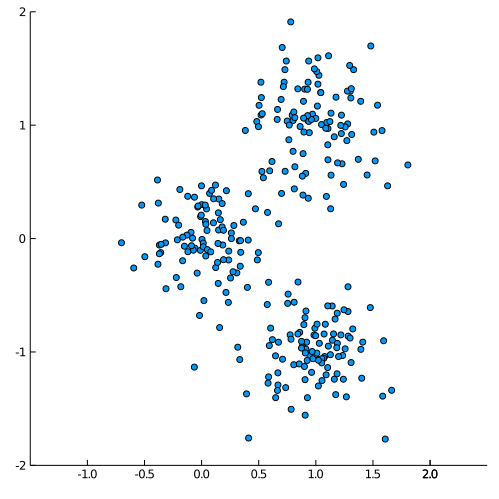

In [8]:
X = vcat( [ 0.3*randn(2) for i = 1:100 ],
[ [1,1] + 0.3*randn(2) for i = 1:100 ],
[ [1,-1] + 0.3*randn(2) for i = 1:100 ] )

scatter([x[1] for x in X], [x[2] for x in X])
plot!(legend = false, grid = false, size = (500,500), xlims = (-1.5,2.5), ylims = (-2,2))

**Figure 4.1** 300 points in a plane.

On the first line we generate three arrays of vectors. Each set consists of 100 vectors chosen randomly around one of the three points `(0, 0)`, `(1, 1)`, and `(1,−1)`. The three arrays are concatenated using `vcat` to get an array of 300 points. 

Next, we apply our kmeans function and make a figure with the three clusters (Figure 4.2).

In [9]:
k = 3
assignment, reps = kmeans(X, k)

Iteration 1: Jclust = 1.0012050654597342.
Iteration 2: Jclust = 0.3455457449745553.
Iteration 3: Jclust = 0.19463151892764938.
Iteration 4: Jclust = 0.16913564280156565.
Iteration 5: Jclust = 0.16873042933924126.
Iteration 6: Jclust = 0.16873042933924126.


([1, 1, 1, 1, 1, 1, 1, 1, 1, 1  …  3, 3, 3, 3, 3, 3, 3, 3, 3, 3], [[0.0371715516278472, -0.0050437311865599846], [0.9860313737990888, 1.0266675085002572], [0.9799369871492959, -1.0012157337297807]])

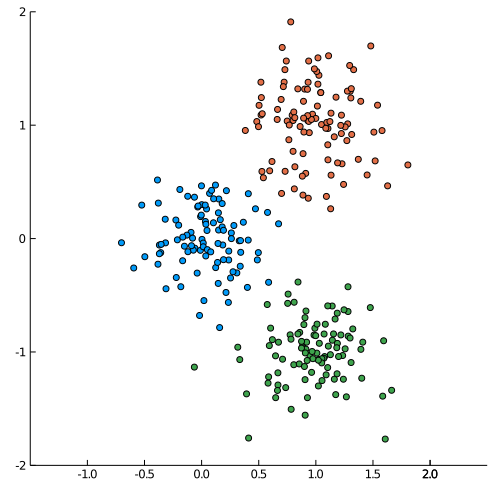

In [10]:
N = length(X)
grps = [[X[i] for i=1:N if assignment[i] == j] for j=1:k]

scatter([c[1] for c in grps[1]], [c[2] for c in grps[1]])
scatter!([c[1] for c in grps[2]], [c[2] for c in grps[2]])
scatter!([c[1] for c in grps[3]], [c[2] for c in grps[3]])

plot!(legend = false, grid = false, size = (500,500), xlims = (-1.5,2.5), ylims = (-2,2))

**Figure 4.2** Final clustering

### 4.4 Examples

### 4.5 Applications